In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('EDA_Cleaning').getOrCreate()

gcs_path = "gs://my-bigdata-project-ma/landing/itineraries.csv"
sdf = spark.read.option("delimiter", ",").option("header", True).csv(gcs_path)

sdf.show(5)

24/10/25 14:49:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/10/25 14:49:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDi

In [3]:
num_observations = sdf.count()
print(f"Number of observations:{num_observations}")

Number of observations:82138753


In [9]:
print("Number of observations: ", sdf.count())

Number of observations:  82138753


In [4]:
sdf.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: string (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: str

In [5]:
from pyspark.sql.functions import col, isnan, when, count
missing_data = sdf.select([count(when(col(c).isNull(), c)).alias(c) for c in sdf.columns])
num_of_missing = missing_data.first()  
total_count = sum(num_of_missing)

print(f"Total number of missing values: {total_count}")

Total number of missing values: 7652124


In [6]:
from pyspark.sql.functions import col, min, max, avg, stddev
numeric_var = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
stats = sdf.select(
    [min(col(c)).alias(f"{c}_min") for c in numeric_var] +
    [max(col(c)).alias(f"{c}_max") for c in numeric_var] +
    [avg(col(c)).alias(f"{c}_avg") for c in numeric_var] +
    [stddev(col(c)).alias(f"{c}_stdev") for c in numeric_var]
)

stats_pd = stats.toPandas()
print(stats_pd)

  elapsedDays_min baseFare_min totalFare_min seatsRemaining_min  \
0               0         0.01        100.07                  0   

  totalTravelDistance_min elapsedDays_max baseFare_max totalFare_max  \
0                    1000               2       999.99        999.93   

  seatsRemaining_max totalTravelDistance_max  elapsedDays_avg  baseFare_avg  \
0                  9                     999         0.149653    292.662853   

   totalFare_avg  seatsRemaining_avg  totalTravelDistance_avg  \
0     340.386849            5.976312              1609.903346   

   elapsedDays_stdev  baseFare_stdev  totalFare_stdev  seatsRemaining_stdev  \
0           0.356757      183.188783        196.02951              2.880567   

   totalTravelDistance_stdev  
0                 857.325735  


In [7]:
date_variables= ['searchDate','flightDate']
date = sdf.select(
    [min(col(c)).alias(f"{c}_min") for c in date_variables] +
    [max(col(c)).alias(f"{c}_max") for c in date_variables])
date_stats = date.toPandas()
print(date_stats)

  searchDate_min flightDate_min searchDate_max flightDate_max
0     2022-04-16     2022-04-17     2022-10-05     2022-11-19


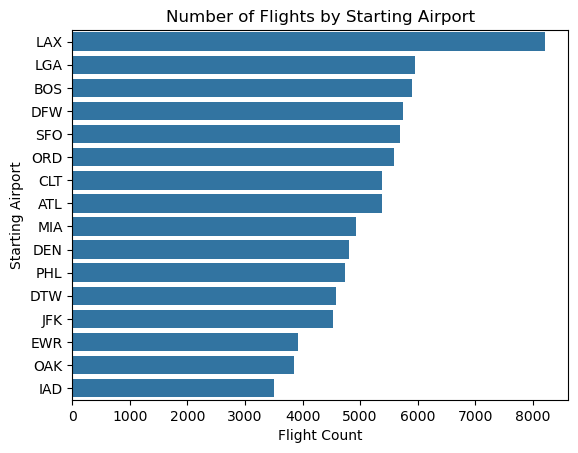

In [13]:
flight_count = sdf_sample['startingAirport'].value_counts()
sns.barplot(x=flight_count.values, y=flight_count.index)
plt.title('Number of Flights by Starting Airport')
plt.xlabel('Flight Count')
plt.ylabel('Starting Airport')
plt.xticks(rotation=360)
plt.show()

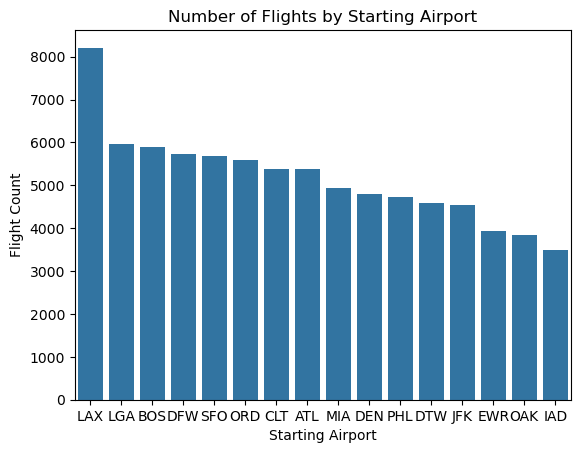

In [14]:
flight_count = sdf_sample['startingAirport'].value_counts()
sns.barplot(x=flight_count.index, y=flight_count.values)
plt.title('Number of Flights by Starting Airport')
plt.xlabel('Starting Airport')
plt.ylabel('Flight Count')
plt.xticks(rotation=360)
plt.show()

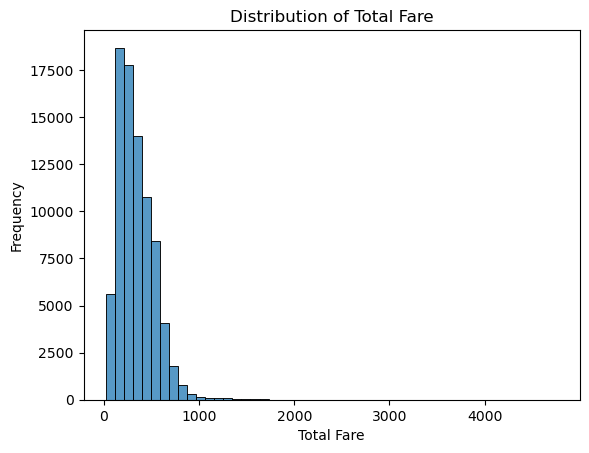

In [10]:
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

sdf = sdf.withColumn("totalFare", col("totalFare").cast("double"))

sdf_sample = sdf.sample(fraction=0.001).toPandas()

sns.histplot(sdf_sample['totalFare'], bins=50)
plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()